In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsmodels.tsa.arima_model import ARIMA

from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\core.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
path = "../data/parquet/dataSetFinalTratadoTop5Diseases.parquet"
df = pd.read_parquet(path)

### Funções Úteis

In [4]:
def verificar_periodo_completo(dataframe, coluna):
    data_mais_antiga = dataframe[coluna].min()
    data_mais_recente = dataframe[coluna].max()
    
    intervalo_completo = pd.period_range(start=data_mais_antiga, end=data_mais_recente, freq='M')
    
    todas_datas_presentes = all(data in dataframe[coluna].values for data in intervalo_completo)

    return data_mais_antiga, data_mais_recente, todas_datas_presentes

In [5]:
def recortar_dataframe(dataframe, coluna, data_inicio, data_fim):
    data_inicio = pd.Period(data_inicio, freq='M')
    data_fim = pd.Period(data_fim, freq='M')
    
    dataframe_recortado = dataframe[(dataframe[coluna] >= data_inicio) & (dataframe[coluna] <= data_fim)]
    
    return dataframe_recortado

In [6]:
def concatenar_datasets(*dataframes):
    dataframe_concatenado = pd.concat(dataframes, ignore_index=True)
    return dataframe_concatenado

In [7]:
def prever_arima(serie_temporal):
    teste_serie_regiao = serie_temporal.groupby('unique_id').tail(12)
    train_serie_regiao = serie_temporal.drop(teste_serie_regiao.index, axis=0)

    models = [AutoARIMA(season_length=12)]

    sf = StatsForecast(
        df=train_serie_regiao,
        models=models,
        freq='M'
    )

    df_forecast = sf.forecast(12, fitted=True).reset_index()
    df_fitted = sf.forecast_fitted_values().reset_index()

    return df_forecast, df_fitted

In [8]:
def modelar_residuos(serie_temporal, forecast, fitted):
    residuos = pd.DataFrame()

    for id in forecast['unique_id'].unique():
        treino = fitted[fitted['unique_id'] == id]
        teste = forecast[forecast['unique_id'] == id].reset_index(drop=True)

        residuos_treino = (treino['AutoARIMA'] - treino['y'])

        teste_serie = serie_temporal[serie_temporal['unique_id'] == id].tail(12).reset_index(drop=True)

        teste['ds'] = teste['ds'] + pd.DateOffset(months=1)

        residuos_teste = (forecast['AutoARIMA'] - teste_serie['y'])
        residuos_totais = pd.concat([residuos_treino, residuos_teste], ignore_index=True)

        coluna_nome = f'residuo_{id}'
        residuos[coluna_nome] = residuos_totais

    return residuos

In [9]:
def criar_lags(data, lag):
    X, y = [], []
    for i in range(lag, len(data)):
        X.append(data[i-lag:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [10]:
def prever_mlp(residuos, window_size):
    df_prev = pd.DataFrame()

    for id in residuos.columns:
        res = residuos[id].values

        # Criar lags
        X, y = criar_lags(res, window_size)

        # Treinamento e teste consistente com ARIMA
        X_train, X_test = X[:-12], X[-12:]
        y_train, y_test = y[:-12], y[-12:]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        mlp = MLPRegressor(hidden_layer_sizes=(100,100), max_iter=500, random_state=42)
        mlp.fit(X_train, y_train)
        y_pred = mlp.predict(X_test)

        prev_full = np.concatenate((mlp.predict(X_train), y_pred), axis=0)

        coluna_nome = f'prev_{id}'
        df_prev[coluna_nome] = prev_full

    return df_prev

In [11]:
def concatenar_datasets(*dataframes):
    dataframe_concatenado = pd.concat(dataframes, ignore_index=True)
    return dataframe_concatenado

### Série Por Região (Sem distinguir doenças)

In [12]:
def pegar_dfs_por_regiao(df_full):
    df_regioes = df_full[['Data de Diagnostico', 'Regiao', 'categoria_doenca']]
    df_regioes['y'] = 1

    df_regioes.dropna(inplace=True)

    df_regioes['year_month'] = df_regioes['Data de Diagnostico'].dt.to_period('M')

    df_grouped = df_regioes.groupby(['year_month', 'Regiao', 'categoria_doenca'])['y'].sum().reset_index()

    df_nordeste = df_grouped[df_grouped['Regiao'] == 'NORDESTE']
    df_sudeste = df_grouped[df_grouped['Regiao'] == 'SUDESTE']
    df_norte = df_grouped[df_grouped['Regiao'] == 'NORTE']
    df_centro_oeste = df_grouped[df_grouped['Regiao'] == 'CENTRO-OESTE']
    df_sul = df_grouped[df_grouped['Regiao'] == 'SUL']

    dfs = [df_nordeste, df_sudeste, df_norte, df_centro_oeste, df_sul]

    serie_nordeste = pd.DataFrame()
    serie_sudeste = pd.DataFrame()
    serie_norte = pd.DataFrame()
    serie_centro_oeste = pd.DataFrame()
    serie_sul = pd.DataFrame()

    for df in dfs:
        mama = df[df['categoria_doenca'] == 'Câncer de Mama']
        prostata = df[df['categoria_doenca'] == 'Câncer de Próstata']
        utero = df[df['categoria_doenca'] == 'Câncer de Colo do Útero']
        pele = df[df['categoria_doenca'] == 'Câncer de Pele']
        pulmao = df[df['categoria_doenca'] == 'Câncer de Pulmão']
        outros = df[df['categoria_doenca'] == 'Outros']

        mama = mama.drop('Regiao', axis=1)
        prostata = prostata.drop('Regiao', axis=1)
        utero = utero.drop('Regiao', axis=1)
        pele = pele.drop('Regiao', axis=1)
        pulmao = pulmao.drop('Regiao', axis=1)
        outros = outros.drop('Regiao', axis=1)

        serie = concatenar_datasets(mama, prostata, utero, pele, pulmao, outros)
        serie.rename(columns={'year_month': 'ds', 'categoria_doenca': 'unique_id'}, inplace=True)
        serie['ds'] = serie['ds'].apply(lambda x: x.to_timestamp())

        if df.equals(df_nordeste):
            serie_nordeste = serie
        elif df.equals(df_sudeste):
            serie_sudeste = serie
        elif df.equals(df_norte):
            serie_norte = serie
        elif df.equals(df_centro_oeste):
            serie_centro_oeste = serie
        elif df.equals(df_sul):
            serie_sul = serie

    return serie_nordeste, serie_sudeste, serie_norte, serie_centro_oeste, serie_sul

In [13]:
serie_nordeste, serie_sudeste, serie_norte, serie_centro_oeste, serie_sul = pegar_dfs_por_regiao(df)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8212\2014146553.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regioes['y'] = 1
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8212\2014146553.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regioes.dropna(inplace=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8212\2014146553.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [14]:
forecast, fitted = prever_arima(serie_nordeste)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\core.py:467: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\core.py:467: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:362: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.

In [15]:
serie_residuos = modelar_residuos(serie_nordeste, forecast, fitted)

In [16]:
serie_residuos.dropna(inplace=True)

### Verificando as Séries

In [17]:
def create_hybrid_series(forecast, residuals):
    category_mapping = {
    'Câncer de Colo do Útero': 'residuo_Câncer de Colo do Útero',
    'Câncer de Mama': 'residuo_Câncer de Mama',
    'Câncer de Pele': 'residuo_Câncer de Pele',
    'Câncer de Próstata': 'residuo_Câncer de Próstata',
    'Câncer de Pulmão': 'residuo_Câncer de Pulmão',
    'Outros': 'residuo_Outros'
    }

    hybrid = forecast.copy()

    for category, residue_col in category_mapping.items():
        hybrid.loc[hybrid['unique_id'] == category, 'AutoARIMA'] += residuals[residue_col].values[-12:]
        
    return hybrid

In [18]:
def plot_all_series(series, forecast, hybrid):
    unique_ids = series['unique_id'].unique()
    
    for uid in unique_ids:
        plt.figure(figsize=(12, 6))
        
        series_temp = series[series['unique_id'] == uid]
        forecast_temp = forecast[forecast['unique_id'] == uid]
        hybrid_temp = hybrid[hybrid['unique_id'] == uid]
        
        plt.plot(series_temp['ds'], series_temp['y'], label='Treino')
        plt.plot(forecast_temp['ds'], forecast_temp['AutoARIMA'], label='Previsão em ARIMA')
        plt.plot(hybrid_temp['ds'], hybrid_temp['AutoARIMA'], label='Previsão em ARIMA-MLP')
        
        plt.title(f'Série Temporal para {uid}')
        plt.xlabel('Data')
        plt.ylabel('Valores')
        plt.legend()
        plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8212\2661913416.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[16.33739281 26.89149475  8.80762672 20.56156921 28.8007164  25.56550217
 22.45389748 19.61779976 18.42393112 20.0327549  26.22285843 49.0934124 ]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hybrid.loc[hybrid['unique_id'] == category, 'AutoARIMA'] += residuals[residue_col].values[-12:]


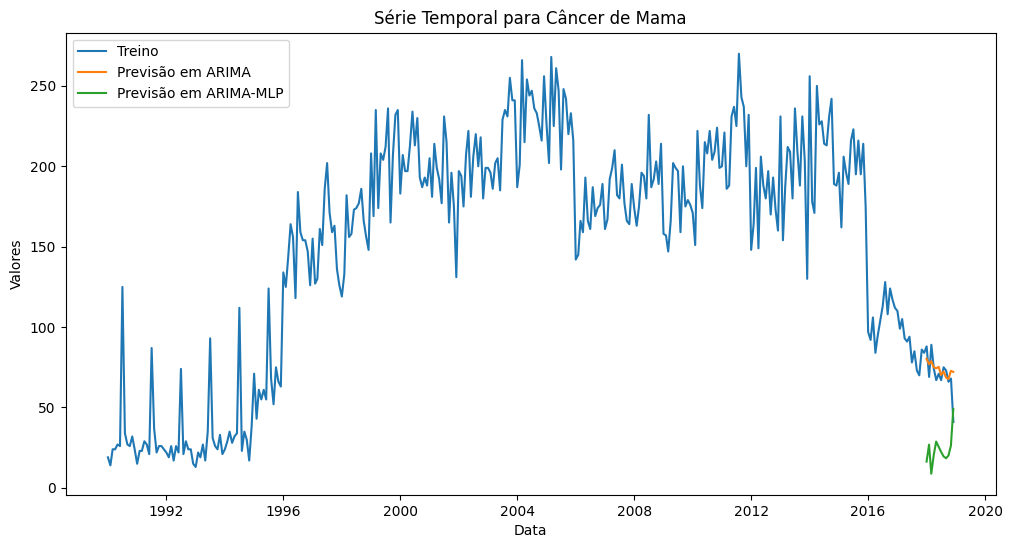

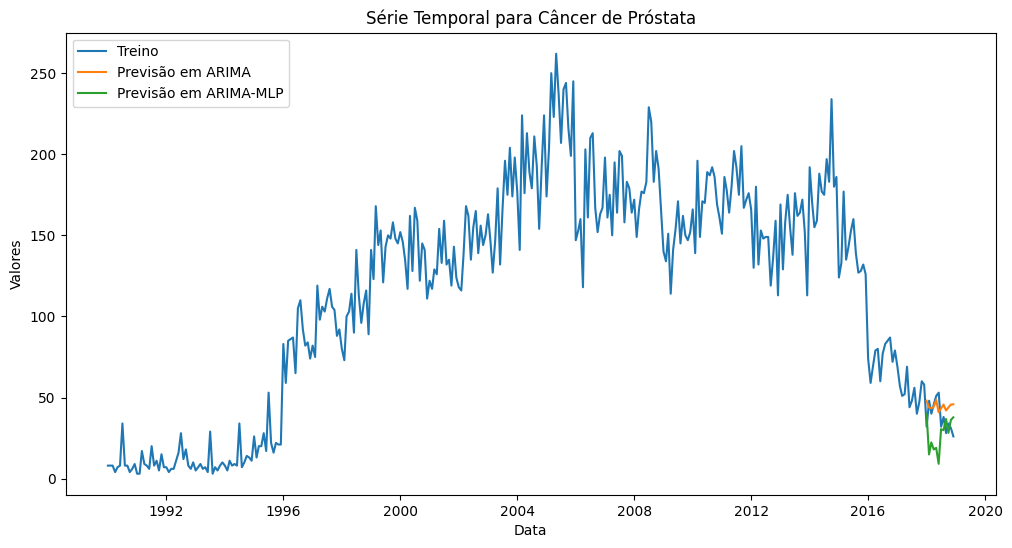

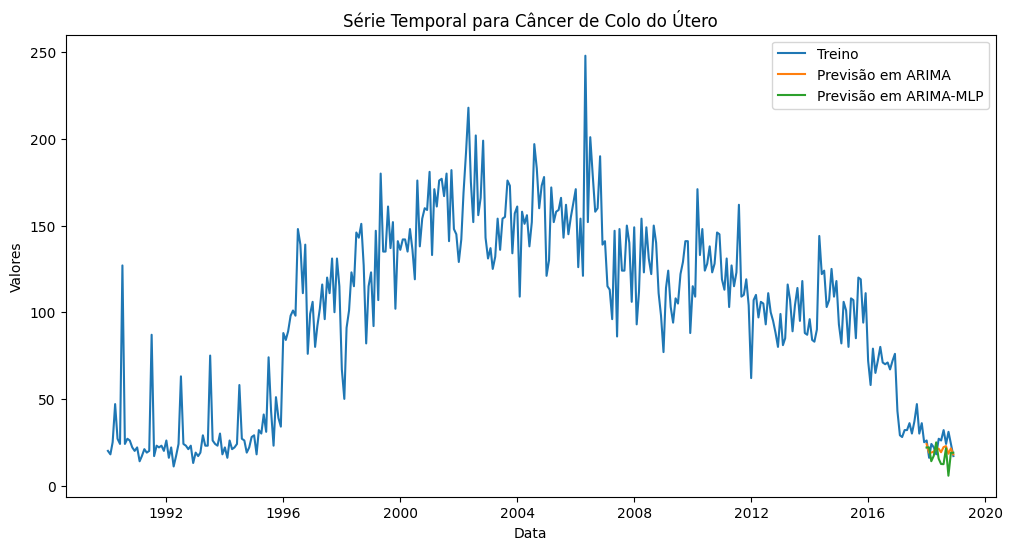

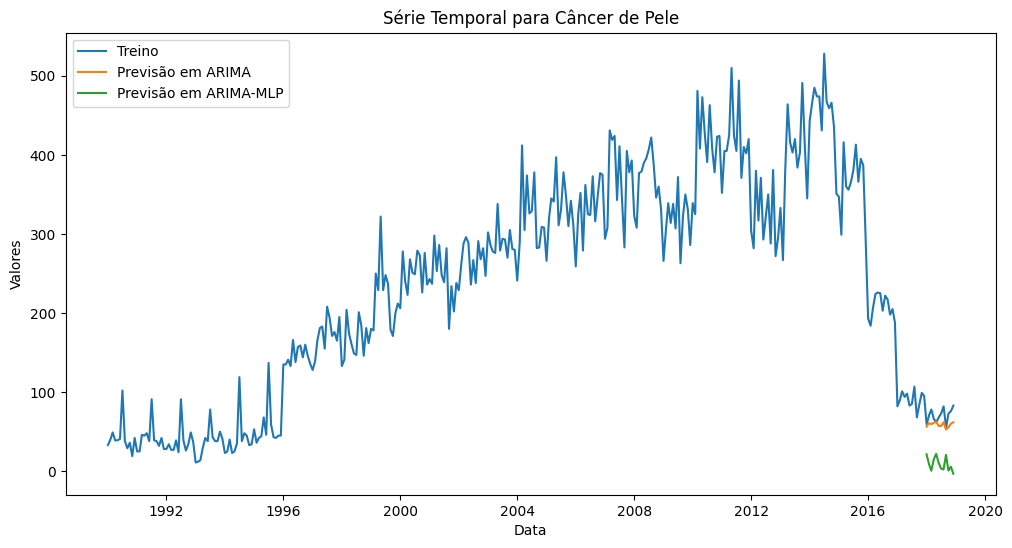

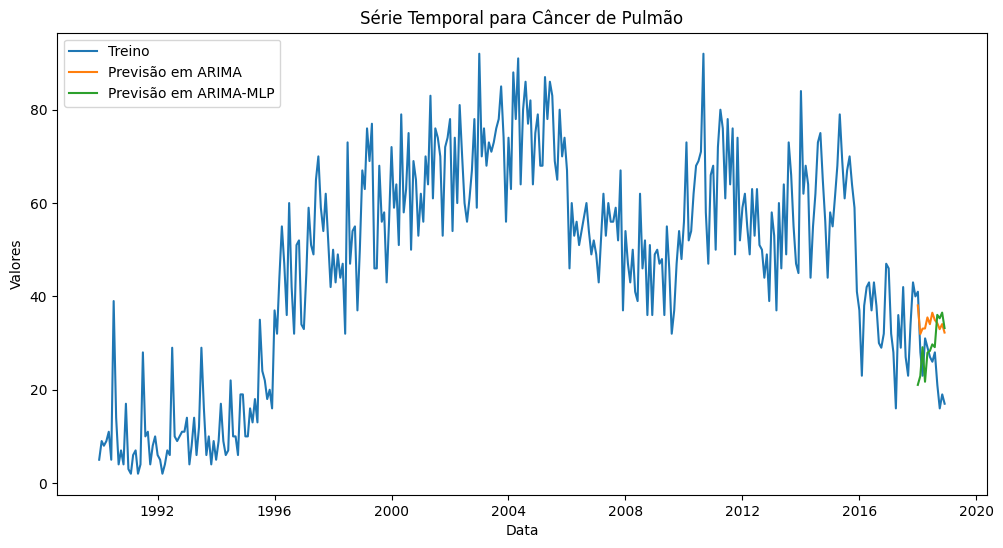

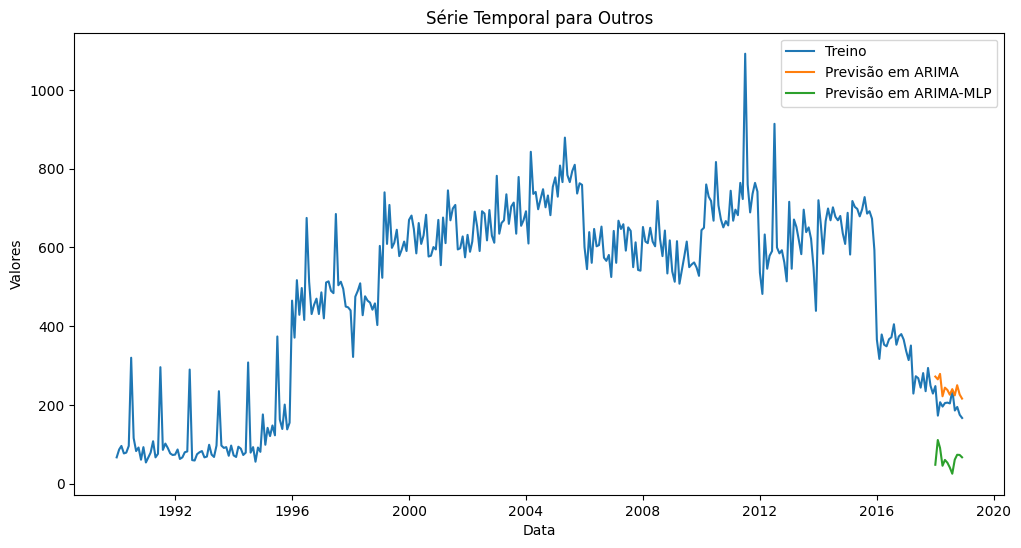

In [19]:
plot_all_series(serie_nordeste, forecast, create_hybrid_series(forecast, serie_residuos))